In [1]:
import kaggle
import os

os.environ['KAGGLE_CONFIG_DIR'] = "/Users/tungdinh/kaggle"

!kaggle datasets download -d faizalkarim/flood-area-segmentation 

In [2]:
from zipfile import ZipFile
file_name = 'flood-area-segmentation.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
    zip.extractall('datasets')
    print('Done')

Done


In [36]:
#import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import cv2

from util import load_data, preprocess_data, display_data
from unet import unet_s, unet_m

In [37]:
physical_devices = tf.config.list_physical_devices('GPU')
print('GPU is available' if len(physical_devices) > 0 else 'Not available')

GPU is available


In [38]:
# initialize input size and shape
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3) # color images, 3 channels

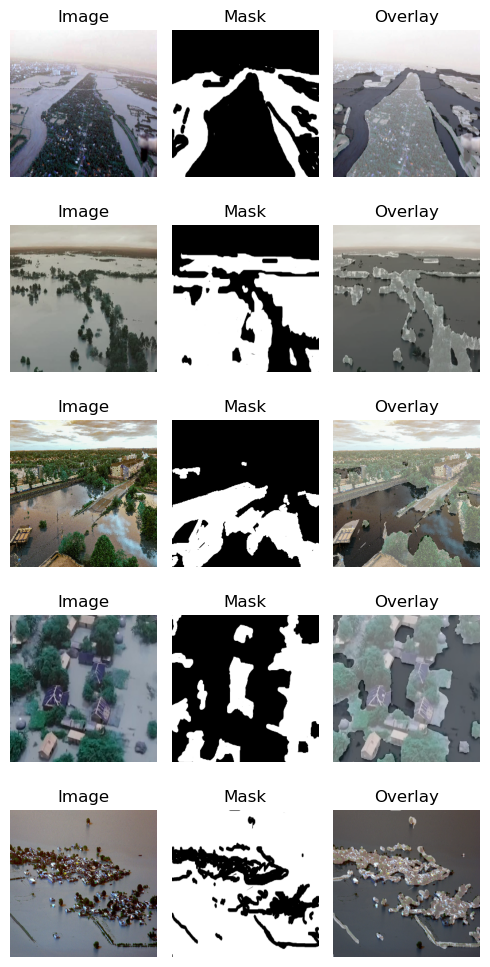

In [39]:
import random

# load data
dir_path = 'datasets/'
image_filenames, mask_filenames = load_data(dir_path)

# display the first 5 pairs of image and mask
random_indices = random.sample(range(0, len(image_filenames)), 5)
display_data(dir_path, image_filenames[random_indices], mask_filenames[random_indices], resize=INPUT_SIZE)

In [40]:
from tensorflow.image import flip_left_right, flip_up_down, adjust_brightness, rot90

def augment(features, labels):
    
    augmented_features = []
    augmented_labels = []
    
    for feature, label in zip(features, labels):
        augmented_features.append(feature)
        augmented_features.append(flip_left_right(feature))
        augmented_features.append(flip_up_down(feature))
        rotated_img = rot90(feature)
        augmented_features.append(rotated_img)
        augmented_features.append(flip_left_right(rotated_img))
        augmented_features.append(flip_up_down(rotated_img))
        
        augmented_labels.append(label)
        augmented_labels.append(flip_left_right(label))
        augmented_labels.append(flip_up_down(label))
        rotated_label = rot90(label)
        augmented_labels.append(rotated_label)
        augmented_labels.append(flip_left_right(rotated_label))
        augmented_labels.append(flip_up_down(rotated_label))
    
    augmented_features = np.array(augmented_features)
    augmented_labels = np.array(augmented_labels)
    
    return augmented_features, augmented_labels

In [41]:
# preprocess data
with tf.device("/device:GPU:0"):
    images, masks = preprocess_data(dir_path, image_filenames, mask_filenames, input_size=INPUT_SIZE) 

In [42]:
# get size of the dataset
print('Shape of image data: ' + str(images.shape))
print('Shape of mask data: ' + str(masks.shape))

Shape of image data: (290, 256, 256, 3)
Shape of mask data: (290, 256, 256, 1)


<b>There are 290 images and corresponding masks in this dataset, which can be considered small. To expand the dataset, we will utilize augmentation techniques. However, we will train the model using both the original non-augmented dataset and the augmented dataset. This approach will allow us to determine if the augmentation techniques enhance the model's performance</b>

In [43]:
# Split the dataset into training and validation sets
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


In [44]:
# split further to train and val sets
org_train_images, org_val_images, org_train_masks, org_val_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

print('Number of train images: ' + str(org_train_images.shape))
print('Number of val images: ' + str(org_val_images.shape))

Number of train images: (185, 256, 256, 3)
Number of val images: (47, 256, 256, 3)


<b>Originally, after splitting, we have 185 train images and 47 val images</b>

In [45]:
# Apply augmentation
with tf.device("/GPU:0"):
    augmented_train_images, augmented_train_masks = augment(train_images, train_masks)
    aug_train_images, aug_val_images, aug_train_masks, aug_val_masks = train_test_split(augmented_train_images, augmented_train_masks, test_size=0.2, random_state=42)

print('Number of train images after aumentation: ' + str(aug_train_images.shape))
print('Number of val images after augmentation: ' + str(aug_val_images.shape))

Number of train images after aumentation: (1113, 256, 256, 3)
Number of val images after augmentation: (279, 256, 256, 3)


<b>After augmentation, we increase the size of train images to 1113 and val images to 279</b>

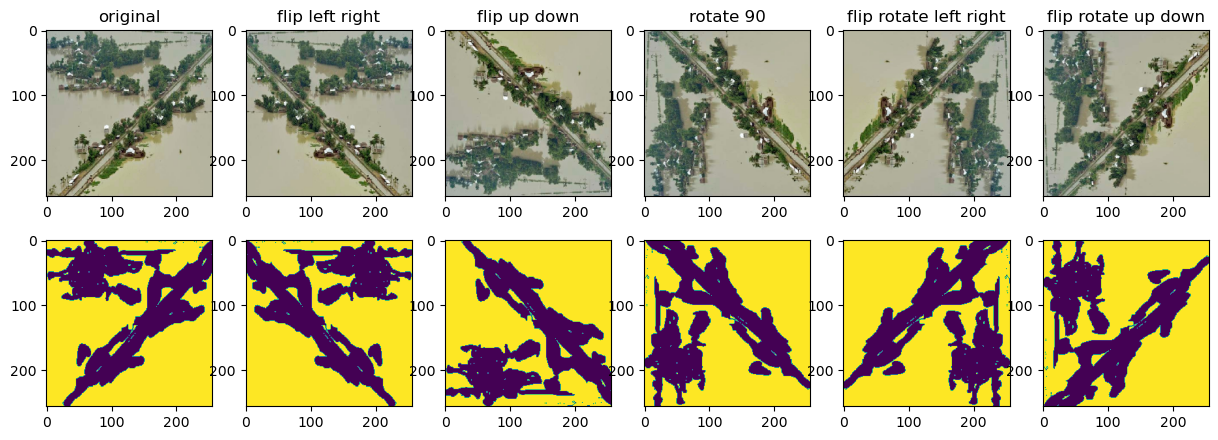

In [69]:
# Dsiplay the augmented images
fig, axes = plt.subplots(2, 6, figsize=(15, 5))

labels = ['original', 'flip left right', 'flip up down', 'rotate 90', 'flip rotate left right', 'flip rotate up down']
for i in range(6):
    axes[0, i].imshow(augmented_train_images[24 + i])
    axes[0, i].set_title(labels[i])
    axes[1, i].imshow(augmented_train_masks[24 + i])

plt.savefig('augment.png', bbox_inches='tight')  # Save as PNG image
plt.show()

<b> Since the masks having asymetric and organic shape, we're allowed to rotate and flip the images as above</b>

In [51]:
# Initialize the model
model = unet_s(INPUT_SHAPE, output_layer=1)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_72 (BatchN  (None, 256, 256, 16  64         ['conv2d_76[0][0]']              
 ormalization)                  )                                                           

In [52]:
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best_org.h5', verbose=1, save_best_only=True)
# complie the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [53]:
epochs = 20
with tf.device("/GPU:0"):
    history = model.fit(org_train_images, org_train_masks, batch_size=8, epochs=epochs, validation_data=(org_val_images, org_val_masks), callbacks=[checkpoint])

Epoch 1/20
24/24 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.7424
Epoch 1: val_loss improved from inf to 32.69217, saving model to models/save_best_org.h5
24/24 [==============================] - 9s 253ms/step - loss: 0.5399 - accuracy: 0.7424 - val_loss: 32.6922 - val_accuracy: 0.4245
Epoch 2/20
24/24 [==============================] - ETA: 0s - loss: 0.4147 - accuracy: 0.8149
Epoch 2: val_loss improved from 32.69217 to 8.28518, saving model to models/save_best_org.h5
24/24 [==============================] - 4s 181ms/step - loss: 0.4147 - accuracy: 0.8149 - val_loss: 8.2852 - val_accuracy: 0.5878
Epoch 3/20
24/24 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8332
Epoch 3: val_loss improved from 8.28518 to 2.56143, saving model to models/save_best_org.h5
24/24 [==============================] - 4s 176ms/step - loss: 0.3886 - accuracy: 0.8332 - val_loss: 2.5614 - val_accuracy: 0.6122
Epoch 4/20
24/24 [==============================] 

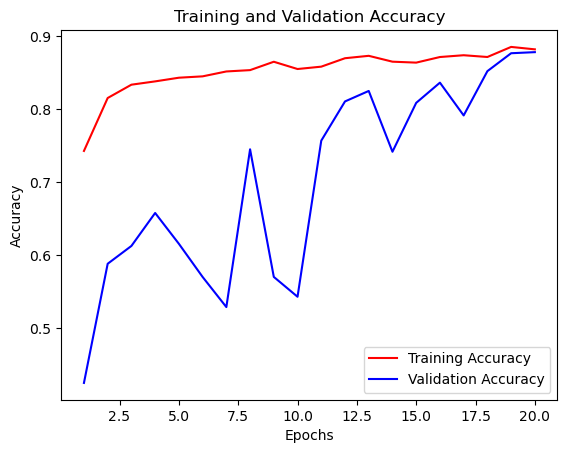

In [54]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy_on_Original_Dataset.png')
plt.show()

<b>The model has signs of overfitting. The val accuracy is only able to catch the train accuracy score after epoch 19. This is expected since we hava a very small dataset. We need to explore different methods, like increasing the size of the dataset, improve its accuracy. </b>


In [55]:
model.save('models/flood-damage-survey-org.h5')

In [56]:
from tensorflow.keras.models import load_model
# load the saved model if needed
model = load_model('models/save_best_org.h5')

eval = model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

2/2 [==============================] - 1s 616ms/step - loss: 0.3465 - accuracy: 0.8603
Test accuracy: 0.86


<b>The test accuracy is matching with both train and val accuracy. This indicates the model is NOT overfitting</b>

<b>Now we're gonna train the model on the datset with augmentation to find out if this will boost its performance</b>

In [57]:
# re-initiate the model 
model = unet_s(INPUT_SHAPE, output_layer=1)
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best_aug.h5', verbose=1, save_best_only=True)
# complie the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [59]:
epochs = 20
with tf.device("/GPU:0"):
    history = model.fit(aug_train_images, aug_train_masks, batch_size=8, epochs=epochs, validation_data=(aug_val_images, aug_val_masks), callbacks=[checkpoint])

Epoch 1/20
140/140 [==============================] - ETA: 0s - loss: 0.3847 - accuracy: 0.8340
Epoch 1: val_loss improved from inf to 0.72222, saving model to models/save_best_aug.h5
140/140 [==============================] - 28s 193ms/step - loss: 0.3847 - accuracy: 0.8340 - val_loss: 0.7222 - val_accuracy: 0.7168
Epoch 2/20
140/140 [==============================] - ETA: 0s - loss: 0.3667 - accuracy: 0.8430
Epoch 2: val_loss did not improve from 0.72222
140/140 [==============================] - 24s 172ms/step - loss: 0.3667 - accuracy: 0.8430 - val_loss: 0.8288 - val_accuracy: 0.6893
Epoch 3/20
140/140 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8555
Epoch 3: val_loss did not improve from 0.72222
140/140 [==============================] - 24s 171ms/step - loss: 0.3458 - accuracy: 0.8555 - val_loss: 0.7240 - val_accuracy: 0.7329
Epoch 4/20
140/140 [==============================] - ETA: 0s - loss: 0.3401 - accuracy: 0.8576
Epoch 4: val_loss improved from 

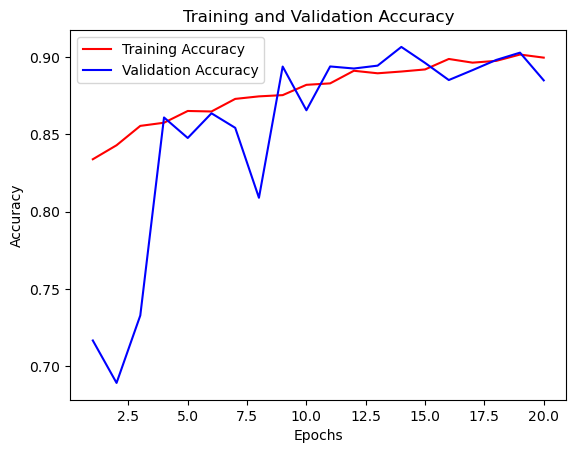

In [60]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy_on_Augmented_Dataset_Batch8.png')
plt.show()

<b>The model trained on the augmneted dataset performed better. The val accuracy is able to catch up with the train accuracy after only a few epochs. However, there is sign of overfitting. We're gonna use the model where the the val loss is the lowest, which is saved duing training</b>

In [61]:
# load the saved model if needed
model = load_model('models/save_best_aug.h5')

eval = model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

2/2 [==============================] - 2s 934ms/step - loss: 0.2613 - accuracy: 0.8978
Test accuracy: 0.90


<b>The test accuracy is improved by 4 points compared to the model that was trained on the original dataset</b>

In [62]:
model.save('models/flood-damage-survey-aug_batch8.h5')

<b>Since we increase the size of the dataset by applying augmentation, the final fine-tuning method is to increase the batch size to find out whether it will boost the performance</b>

In [63]:
# re-initiate the model 
model = unet_s(INPUT_SHAPE, output_layer=1)
# save check point
checkpoint = tf.keras.callbacks.ModelCheckpoint('models/save_best_aug_b16.h5', verbose=1, save_best_only=True)
# complie the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
epochs = 20
with tf.device("/GPU:0"):
    history = model.fit(aug_train_images, aug_train_masks, batch_size=16, epochs=epochs, validation_data=(aug_val_images, aug_val_masks), callbacks=[checkpoint])

Epoch 1/20
70/70 [==============================] - ETA: 0s - loss: 0.4343 - accuracy: 0.8034
Epoch 1: val_loss improved from inf to 1.18529, saving model to models/save_best_aug_b16.h5
70/70 [==============================] - 25s 319ms/step - loss: 0.4343 - accuracy: 0.8034 - val_loss: 1.1853 - val_accuracy: 0.5950
Epoch 2/20
70/70 [==============================] - ETA: 0s - loss: 0.3632 - accuracy: 0.8457
Epoch 2: val_loss did not improve from 1.18529
70/70 [==============================] - 18s 262ms/step - loss: 0.3632 - accuracy: 0.8457 - val_loss: 2.6218 - val_accuracy: 0.6418
Epoch 3/20
70/70 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.8538
Epoch 3: val_loss improved from 1.18529 to 0.72836, saving model to models/save_best_aug_b16.h5
70/70 [==============================] - 19s 265ms/step - loss: 0.3457 - accuracy: 0.8538 - val_loss: 0.7284 - val_accuracy: 0.6399
Epoch 4/20
70/70 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 

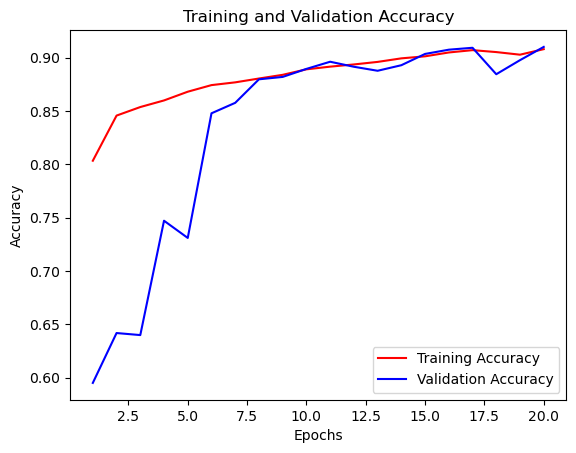

In [66]:
# Accessing training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('Accuracy_on_Augmented_Dataset_Batch16.png')
plt.show()

In [67]:
# load the saved model if needed
model = load_model('models/save_best_aug_b16.h5')

eval = model.evaluate(test_images, test_masks)
print('Test accuracy: ' + "{:.2f}".format(eval[1]))

2/2 [==============================] - 2s 720ms/step - loss: 0.2807 - accuracy: 0.8889
Test accuracy: 0.89


<b>Even though the model performs betetr while training, the test score is less than the previous model when the batch size is 8</b>

<b>Displaying the 10 random predictions on the test data</b>

1/1 [==============================] - 1s 583ms/step


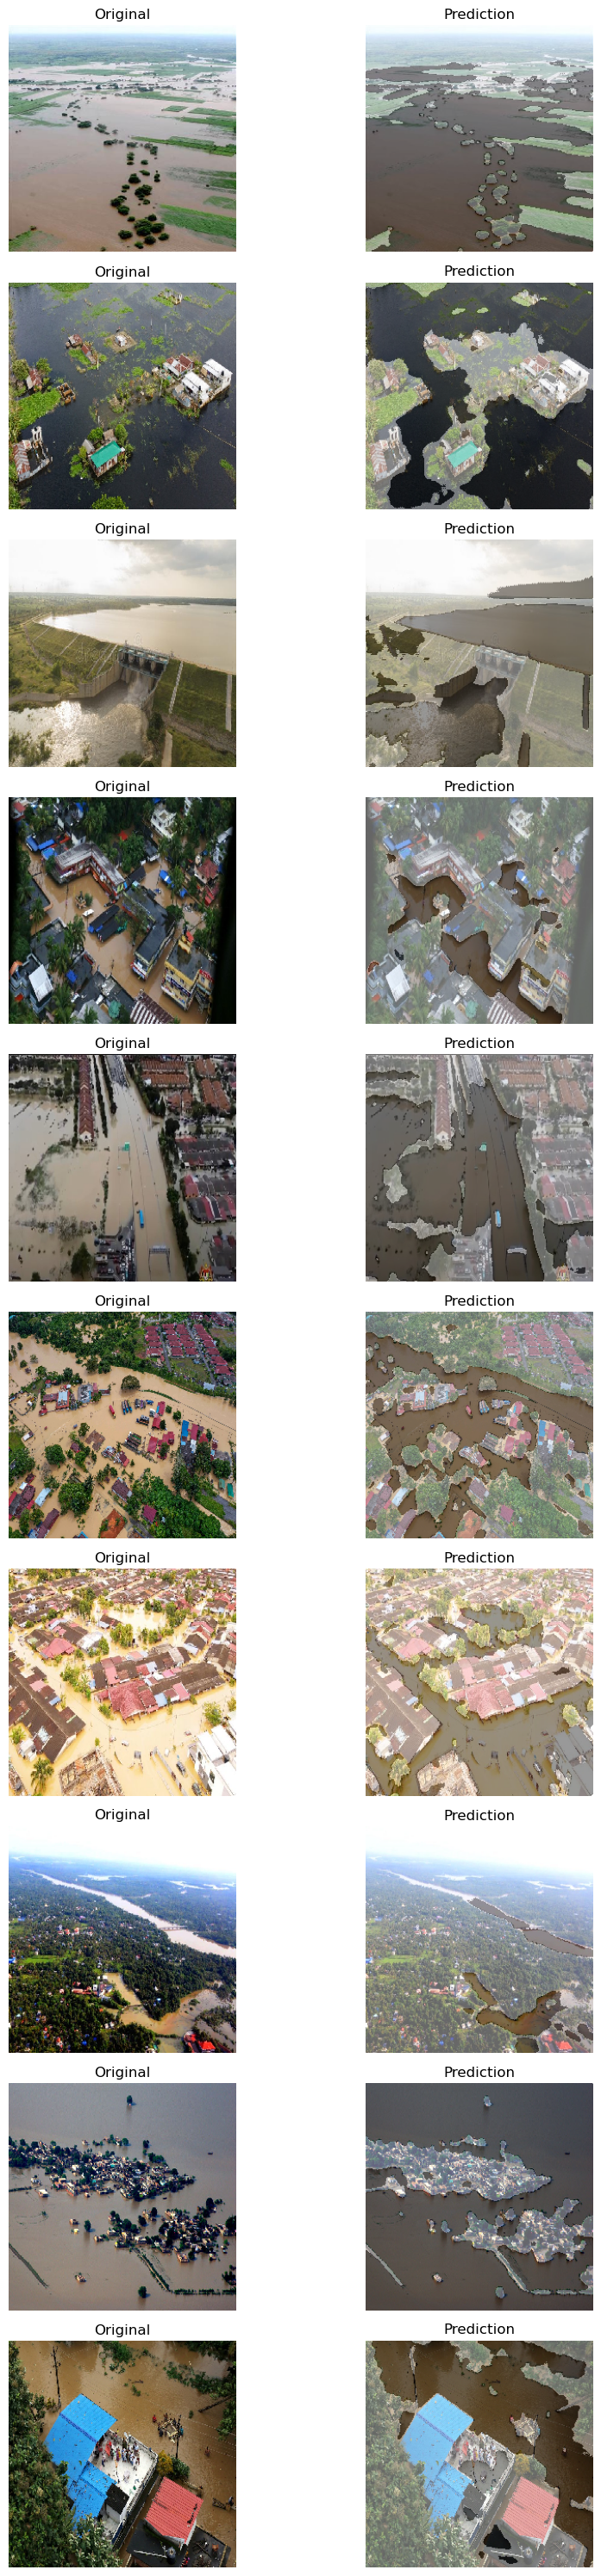

In [95]:
# display 10 random predictions
model = load_model('models/save_best_aug.h5')

random_indices = random.sample(range(0, len(test_images)), 10)
test_sample = test_images[random_indices]

predictions = model.predict(test_sample)
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(10, 2, figsize=(10, 3*10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(test_sample)):

    image = (test_sample[i] * 255).astype(np.uint8)
    mask = predictions[i]
    ground_truth = test_masks[random_indices][i] * np.array([255, 255, 255]) # convert the forground into yellow color to achieve the desired aesthetic

    overlay = image.copy()

    #mask = np.repeat(mask, 3, axis=2) # matching the size of the channel of the mask and the image to perform an overlay
    inverted_mask = 1 - mask

    #mask = np.array([255, 255, 255]) * mask

    # Apply the mask on the image
    # result = image * inverted_mask + yellow_mask
    alpha = 0.4
    #predicted_overlay = cv2.addWeighted(overlay, alpha, result.astype(overlay.dtype), 1 - alpha, 0)

    # Plot the image and mask in the corresponding subplot
    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(image)
    axes[i, 1].imshow(tf.squeeze(cv2.bitwise_not(mask)), cmap='gray', alpha=0.4)
    axes[i, 1].set_title('Prediction')
    axes[i, 1].axis('off')
    
# Adjust the spacing between subplots
plt.tight_layout()
plt.savefig('result.png', bbox_inches='tight')  # Save as PNG image

# Show the plot
plt.show()


<b>Conclusion: From the plot, we must acknowledge that the model performs very well. It's able to mask out the flooded region in details even when the water areas are very small and clustered.</b>

1/1 [==============================] - 0s 33ms/step


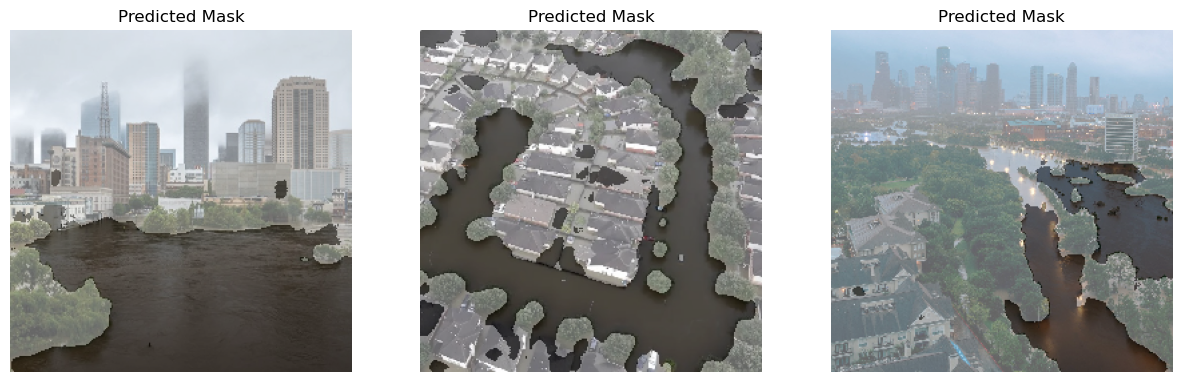

In [94]:
# test on found images on the internet regarding Houston's flood
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

dir_path = 'test_images/'
houston = []
for filename in os.listdir(dir_path):
    img = load_img(os.path.join(dir_path, filename), target_size=(256, 256), color_mode='rgb')
    img = img_to_array(img)
    img = img / 255
    houston.append(img)
    

predictions = model.predict(np.array(houston))
predictions = (predictions > 0.5).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 10))

# Iterate over the image and mask pairs and display them in subplots
for i in range(len(predictions)):

    image = (houston[i] * 255).astype(np.uint8)
    mask = predictions[i]
    
    overlay = image.copy()

    inverted_mask = 1 - mask

    alpha = 0.4

    # Plot the image and mask in the corresponding subplot
    axes[i].imshow(image)
    axes[i].imshow(tf.squeeze(cv2.bitwise_not(mask)), cmap='gray', alpha=0.4)
    axes[i].set_title('Predicted Mask')
    axes[i].axis('off')
    
   
    
plt.savefig('houston_predicted.png')
plt.show()
